In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def set_gnuplot_style():
    mpl.rcParams.update({

        # --- Figura ---
        "figure.figsize": (6.0, 4.0),
        "figure.dpi": 120,
        "figure.facecolor": "white",

        # --- Ejes ---
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.0,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "axes.grid": False,

        # --- Ticks (muy importante para look gnuplot) ---
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "xtick.top": True,
        "ytick.right": True,

        # --- Líneas ---
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0.8,

        # --- Leyenda ---
        "legend.frameon": False,
        "legend.fontsize": 10,
        "legend.handlelength": 2.5,

        # --- Fuentes ---
        "font.family": "serif",
        "font.size": 12,

        # --- Guardado ---
        "savefig.bbox": "tight",
        "savefig.dpi": 300
    })


# SIR Density chart

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import functools

def process_rate(i):
    """Procesa todas las repeticiones para una tasa específica"""
    rate = i/100
    integrals = []
    outbreak_size = []
    
    for j in range(1, 31):
        filename = f"../output/stats-SIR-I=   {rate:.5f}-R=   1.00000-S={42069+j}.dat"
        df = pd.read_csv(filename, sep=r'\s+', header=None, 
                        names=['t', 'irate', 'rrate', 'idens', 'rdens'], 
                        engine='python')
        if (df['idens'].max() < 0.2):
            continue
        
        df['sdens'] = 1 - df['rdens'] - df['idens']
        integrals.append(np.trapezoid(df['idens'], df['t']))
        outbreak_size.append(df['rdens'].iloc[-1])
    if (len(integrals) == 0):
        integrals = [0]
    if (len(outbreak_size) == 0):
        outbreak_size = [0]
    return {
        "rate": rate,
        "integral": np.mean(integrals),
        "err_integral": np.std(integrals),
        "outbreak_size": np.mean(outbreak_size),
        "err_outbreak_size": np.mean(outbreak_size)
    }

# Paralelización simple
if __name__ == "__main__":
    rates = range(2, 200+1, 2)
    
    with Pool() as pool:
        results = list(tqdm(pool.imap(process_rate, rates), 
                           total=len(rates)))
    
    dfs = pd.DataFrame(results)

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


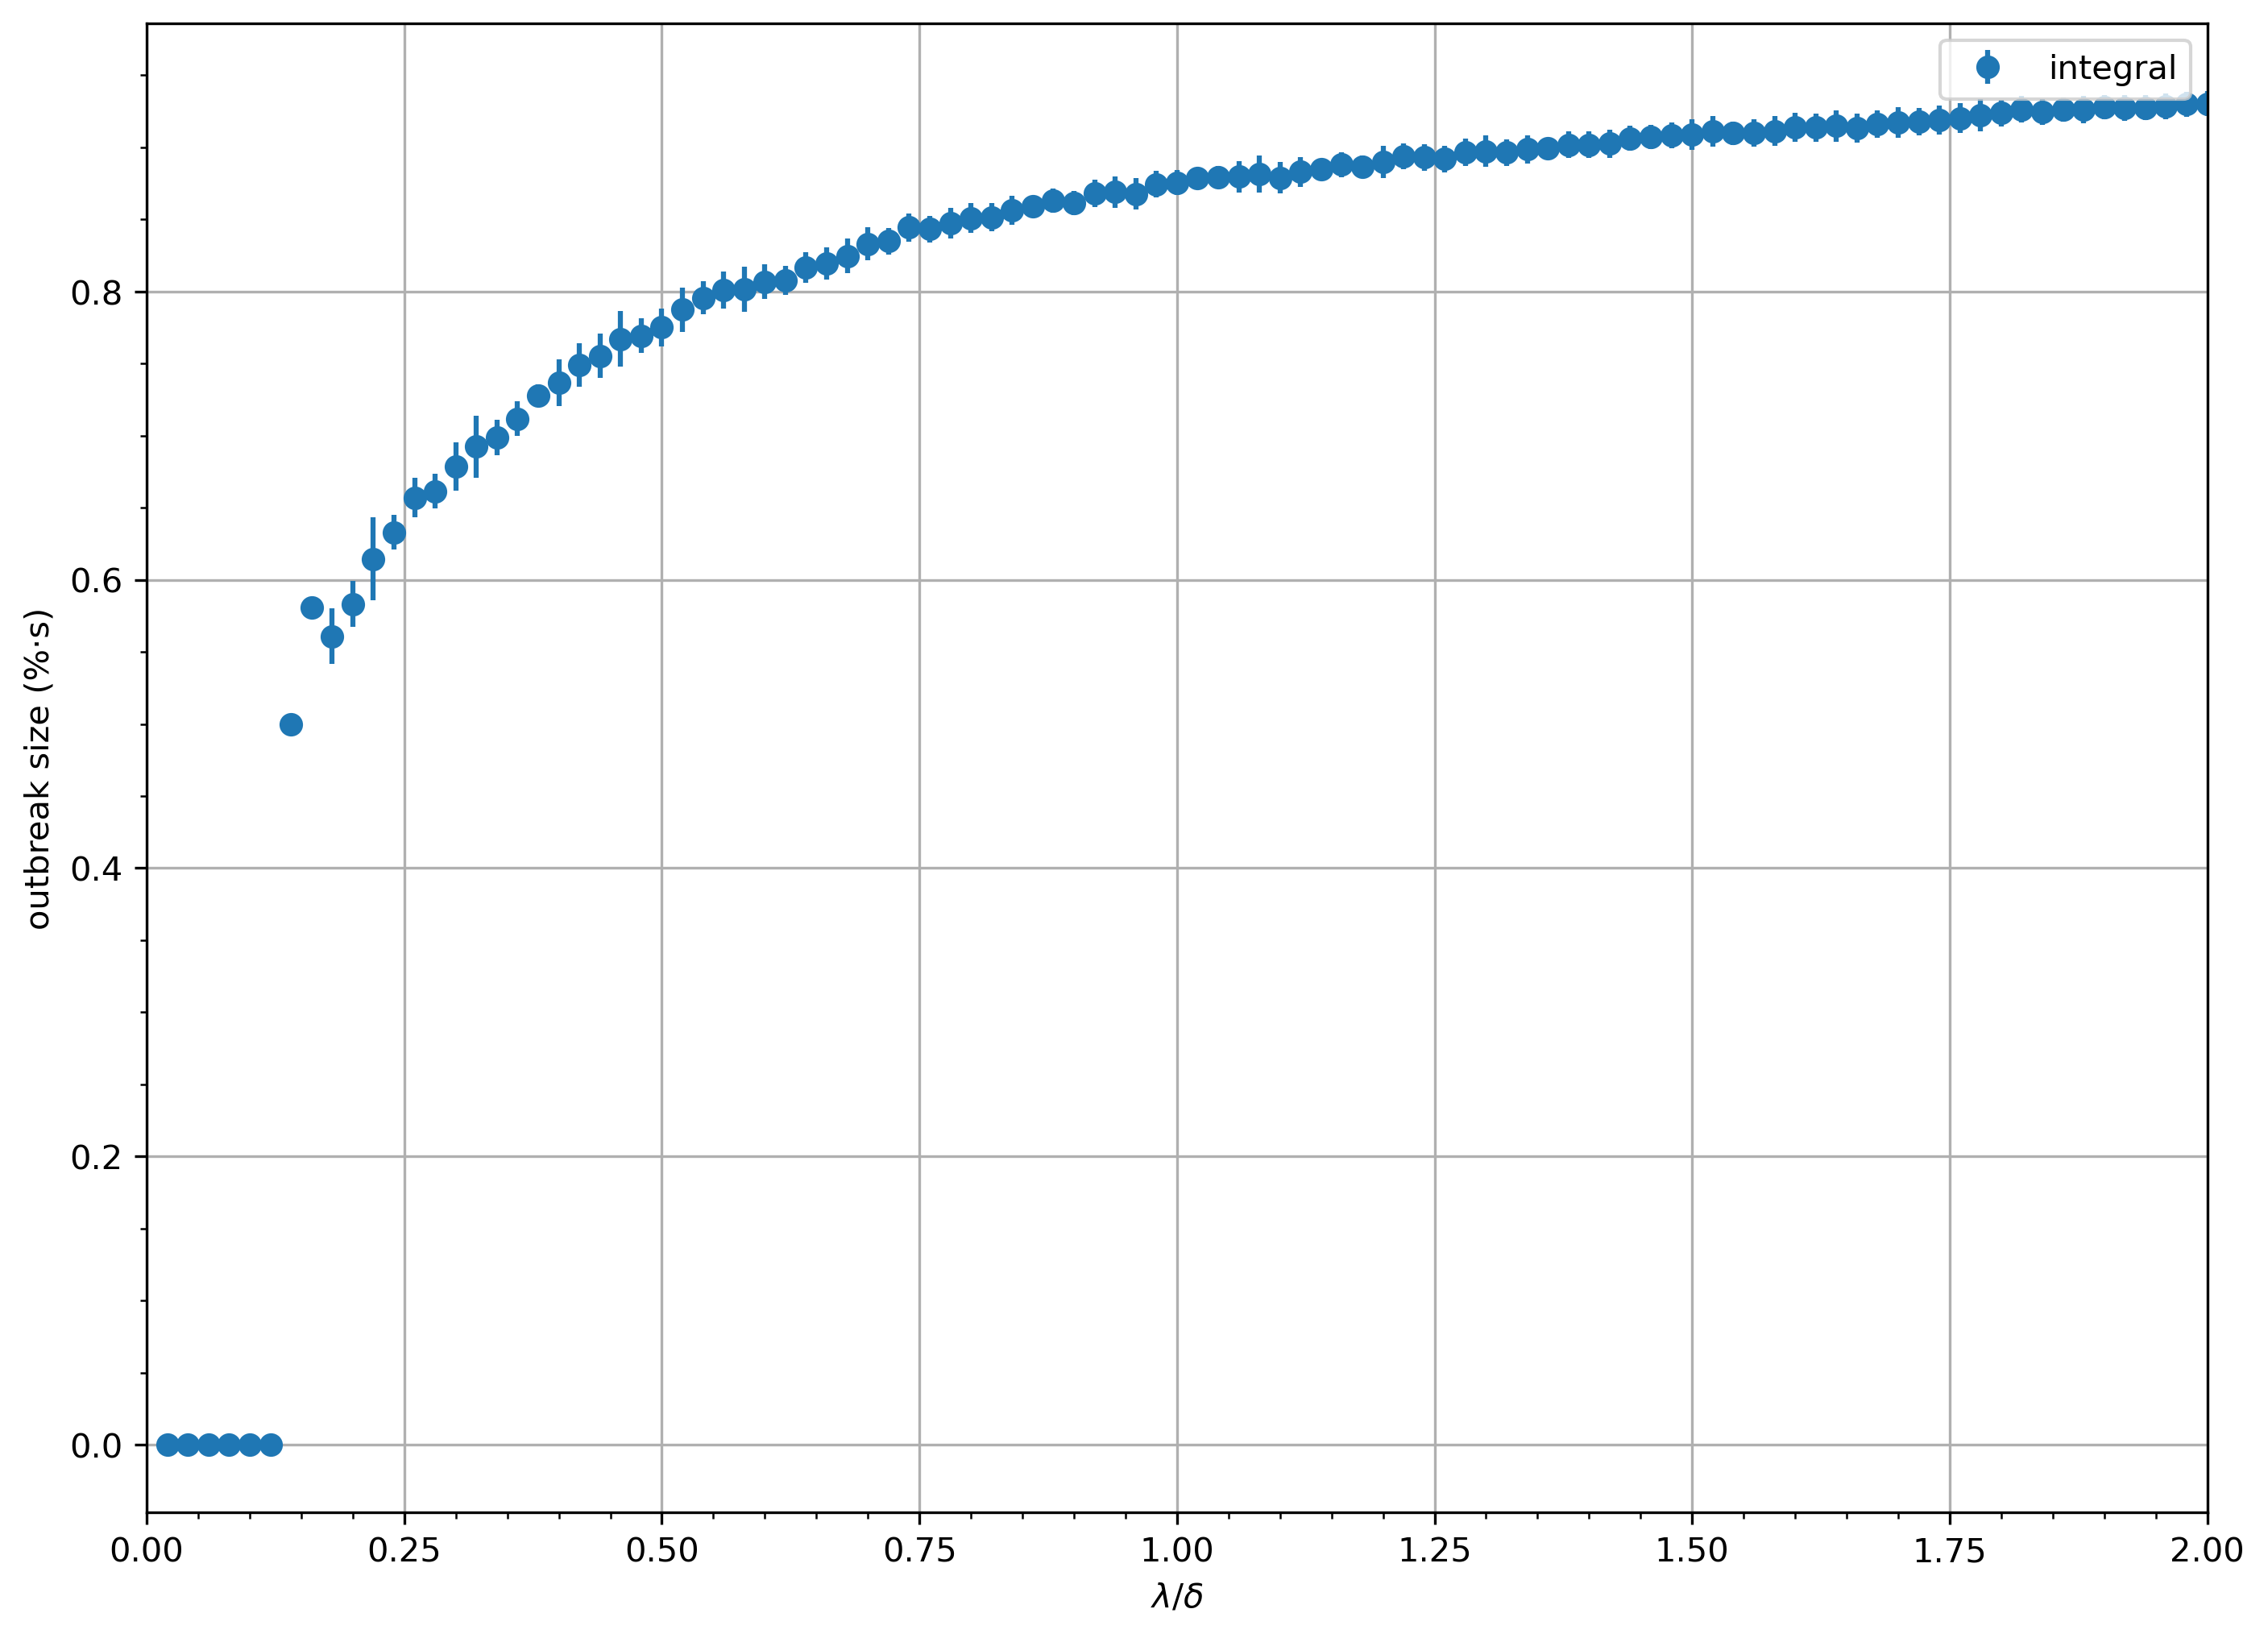

In [56]:
# set_gnuplot_style()
fig, ax = plt.subplots(figsize=(11, 8), dpi=300)
ax.minorticks_on()
# ax.errorbar(dfs['rate'], dfs['outbreak_size'], yerr=dfs['err_outbreak_size'], marker='o', linestyle='none', label='outbreak')
ax.errorbar(dfs['rate'], dfs['integral'], yerr=dfs['err_integral'], marker='o', linestyle='none', label='integral')
# ax.scatter(df_data['x'], df_data['y'], marker='o')
ax.set_xlabel(r'$\lambda/\delta$')
ax.set_xlim(0, 2)
ax.legend()
# ax.set_ylim(0)
ax.set_ylabel('outbreak size (%·s)')
ax.grid()
plt.show()